In [75]:
%config IPCompleter.greedy=True

import itertools
import os
import pandas as pd
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import cv2
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


TF version: 2.3.1
Hub version: 0.7.0
GPU is available


In [76]:
##### Get Voc Training Dataset
voc_dir = r"D:\voc2007"

labels = ["person", "car", "bus", "bicycle", "motorbike", "aeroplane"]

data_train_all = pd.DataFrame(columns=["img_id"] + labels)
data_val_all = pd.DataFrame(columns=["img_id"] + labels)

# Get Dataset and put it into a table
for i in range(len(labels)):
    data_train = pd.read_csv(voc_dir + '\ImageSets\Main\{}_train.txt'.format(labels[i]),header = None,index_col=False ,delim_whitespace=True, dtype={0:np.str, 1:np.int})
    data_val = pd.read_csv(voc_dir + '\ImageSets\Main\{}_val.txt'.format(labels[i]), header= None ,index_col=False ,delim_whitespace=True, dtype={0:np.str, 1:np.int})
    
    if(i == 0):
        data_train_all['img_id'] = data_train[0]
        data_val_all['img_id']  = data_val[0]

    data_train_all[labels[i]] = data_train[1]
    data_val_all[labels[i]]  = data_val[1]


In [77]:
##### Data Preprocessing
dataset_train_counter = {x:0 for x in labels}
rows_to_del_train = []

# get no. objects in dataset + delete rows with no relative objects
for i in range(len(data_train_all.index)):
    row = data_train_all.iloc[i]
    counter = 0
    for label in labels:
        
        if(row[label] == 1):
            dataset_train_counter[label] += 1
        elif(row[label] == -1):
            counter += 1
        
    if(counter == len(labels)):
        rows_to_del_train.append(row['img_id'])

# max_vals_train = max(dataset_train_counter, key=dataset_train_counter.get)

# delete rows with people to reduce bias
data_train_person = data_train_all.loc[data_train_all['person'] == 1]
how_many_person_to_delete = 500
deleted_person = 0
for i in range(len(data_train_person)):
    if(deleted_person == how_many_person_to_delete):
        break
        
    row = data_train_person.iloc[i]
    
    for label in labels:
        if((row[label] != 'person') & (row[label] == 1)):
            continue
            
    if(counter == (len(labels) - 1)):
        deleted_person += 1
        rows_to_del_train.append(row['img_id'])

dataset_train_counter['person'] =  dataset_train_counter['person'] - how_many_person_to_delete

for img_id in rows_to_del_train:

    data_train_all.drop(data_train_all.loc[data_train_all['img_id'] == img_id].index, inplace=True)
    


In [78]:
# Make a script to seperate data into subfolders

# make validation a 20/80 split
crop_val_rows = int(0.2*(len(data_train_all.index)/(0.8)))
data_val_all = data_val_all[:crop_val_rows]

for label in labels:
    try:
        os.makedirs(voc_dir + r"\voc_submodules_train\{}".format(label))
    except FileExistsError:
        pass
    
    try:
        os.makedirs(voc_dir + r"\voc_submodules_val\{}".format(label))
    except FileExistsError:
        pass

    
for i, row in data_train_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_train\{}\{}.jpg'.format(label, row['img_id']) )
            
for i, row in data_val_all.iterrows():
    for label in labels:
        if(row[label] == 1):
            shutil.copyfile(voc_dir + r'\JPEGImages\{}.jpg'.format(row['img_id']), 
                            voc_dir + r'\voc_submodules_val\{}\{}.jpg'.format(label, row['img_id']) )




In [105]:
train_data_dir =voc_dir + r'\voc_submodules_train\\'
test_data_dir = voc_dir + r'\voc_submodules_val\\'
#try diff scale hyper params
scale = 128 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=50.,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale=1. / scale,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
#         vertical_flip = True
    )

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        test_data_dir,
        shuffle = True,
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1846 images belonging to 6 classes.
Found 259 images belonging to 6 classes.


In [113]:
# classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

model = tf.keras.Sequential([
    # input layer already specified in classifier
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(classifier_model, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                         kernel_regularizer=tf.keras.regularizers.l2(0.0001))

])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_16 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [114]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
#     optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [115]:
history = model.fit(train_generator, 
                    epochs=10,
                    validation_data= val_generator)

Epoch 1/10
58/58 [==============================] - 27s 463ms/step - loss: 1.3748 - accuracy: 0.5406 - val_loss: 1.0038 - val_accuracy: 0.6062
Epoch 2/10
58/58 [==============================] - 26s 449ms/step - loss: 0.9055 - accuracy: 0.6701 - val_loss: 0.8394 - val_accuracy: 0.6757
Epoch 3/10
58/58 [==============================] - 27s 464ms/step - loss: 0.8465 - accuracy: 0.6961 - val_loss: 0.8940 - val_accuracy: 0.6988
Epoch 4/10
58/58 [==============================] - 27s 472ms/step - loss: 0.8518 - accuracy: 0.6934 - val_loss: 0.8376 - val_accuracy: 0.6988
Epoch 5/10
58/58 [==============================] - 26s 456ms/step - loss: 0.7869 - accuracy: 0.7124 - val_loss: 0.8225 - val_accuracy: 0.6834
Epoch 6/10
58/58 [==============================] - 27s 463ms/step - loss: 0.7526 - accuracy: 0.7107 - val_loss: 0.8092 - val_accuracy: 0.6988
Epoch 7/10
58/58 [==============================] - 27s 459ms/step - loss: 0.7426 - accuracy: 0.7151 - val_loss: 0.8597 - val_accuracy: 0.6950

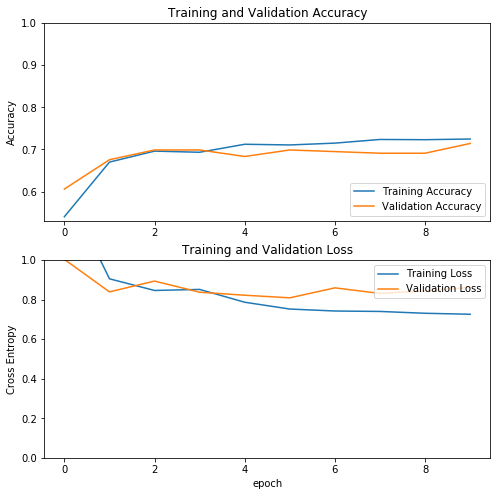

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()